178
570
投影方向w: [-9.38474714e-01  4.70511728e-05  8.16880857e-03 -3.45251327e-01]
测试准确率: 90.54%


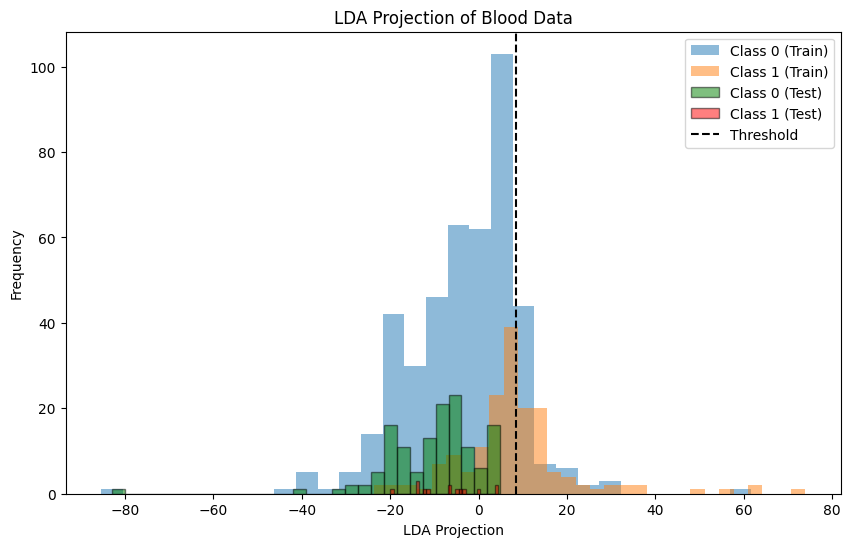

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#读取数据
data = pd.read_csv('blood_data.txt', header=None, skipinitialspace=True)
X = data.iloc[:, :4].values
y = data.iloc[:, 4].values

#划分训练集和测试集
X_train, y_train = X[:600], y[:600]
X_test, y_test = X[600:], y[600:]

#数据标准化（中心化）
mean_overall = np.mean(X_train, axis=0)
X_train_centered = X_train - mean_overall
X_test_centered = X_test - mean_overall

#计算LDA投影方向w
classes = np.unique(y_train)
mean_vectors = []
for cls in classes:
    mean_vectors.append(np.mean(X_train[y_train == cls], axis=0))
mean_overall = np.mean(X_train, axis=0)

#类内散布矩阵 Sw,添加正则化防止奇异矩阵
Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
for cls, mean_vec in zip(classes, mean_vectors):
    cls_data = X_train[y_train == cls]
    cls_scatter = (cls_data - mean_vec).T @ (cls_data - mean_vec)
    Sw += cls_scatter
Sw += 1e-6 * np.eye(Sw.shape[0])  # 正则化项

#类间散布矩阵 Sb
Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
for cls, mean_vec in zip(classes, mean_vectors):
    n = X_train[y_train == cls].shape[0]
    mean_diff = (mean_vec - mean_overall).reshape(-1, 1)
    Sb += n * (mean_diff @ mean_diff.T)

#求解广义特征值问题
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
w = eig_vecs[:, np.argmax(eig_vals)].real

#确保投影方向正确：类别0的投影均值 < 类别1的投影均值
train_proj = X_train @ w
mean0 = np.mean(train_proj[y_train == 0])
mean1 = np.mean(train_proj[y_train == 1])
if mean0 > mean1:
    w = -w  # 反转方向

#重新计算投影和分类阈值
train_proj = X_train @ w
mean0 = np.mean(train_proj[y_train == 0])
mean1 = np.mean(train_proj[y_train == 1])
threshold = (mean0 + mean1) / 2

#动态优化分类阈值
train_proj = X_train_centered @ w
thresholds = np.linspace(train_proj.min(), train_proj.max(), 1000)
accuracies = [np.mean((train_proj > t).astype(int) == y_train) for t in thresholds]
threshold = thresholds[np.argmax(accuracies)]

#测试集预测
test_proj = X_test_centered @ w
y_pred = (test_proj > threshold).astype(int)

#计算准确率
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"投影方向w: {w}")
print(f"测试准确率: {accuracy:.2%}")

#可视化
plt.figure(figsize=(10, 6))
plt.hist(train_proj[y_train == 0], bins=30, alpha=0.5, label='Class 0 (Train)')
plt.hist(train_proj[y_train == 1], bins=30, alpha=0.5, label='Class 1 (Train)')
plt.hist(test_proj[y_test == 0], bins=30, alpha=0.5, label='Class 0 (Test)', color='green', edgecolor='black')
plt.hist(test_proj[y_test == 1], bins=30, alpha=0.5, label='Class 1 (Test)', color='red', edgecolor='black')
plt.axvline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel('LDA Projection')
plt.ylabel('Frequency')
plt.legend()
plt.title('LDA Projection of Blood Data')
plt.show()




投影方向w: [-9.55895783e-01  2.18602200e-05  5.44904411e-03 -2.93655513e-01]
测试准确率: 81.76%
测试F1分数: 18.18%
测试召回率: 21.43%


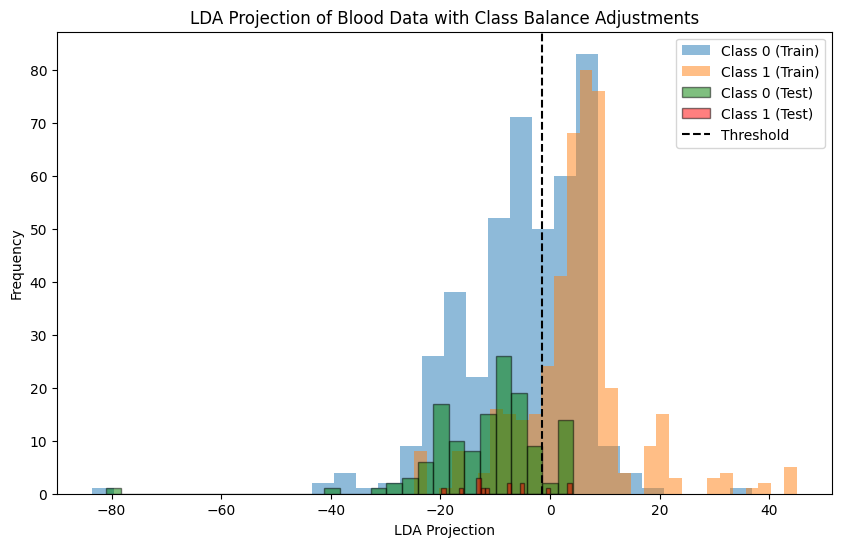

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('blood_data.txt', header=None, skipinitialspace=True)
X = data.iloc[:, :4].values
y = data.iloc[:, 4].values

# 划分训练集和测试集
X_train, y_train = X[:600], y[:600]
X_test, y_test = X[600:], y[600:]

# 随机过采样以平衡类别分布
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
minority_class = min(class_counts, key=class_counts.get)
majority_class = max(class_counts, key=class_counts.get)

minority_data = X_train[y_train == minority_class]
majority_data = X_train[y_train == majority_class]

target_count = class_counts[majority_class]

def random_over_sampling(data, target_size):
    indices = np.random.choice(data.shape[0], size=target_size, replace=True)
    return data[indices]

oversampled_minority = random_over_sampling(minority_data, target_count)
X_train_oversampled = np.vstack((majority_data, oversampled_minority))
y_train_oversampled = np.hstack((np.full(target_count, majority_class), np.full(target_count, minority_class)))

# 使用平衡后的数据集继续后续操作
X_train, y_train = X_train_oversampled, y_train_oversampled

# 数据标准化（中心化）
mean_overall = np.mean(X_train, axis=0)
X_train_centered = X_train - mean_overall
X_test_centered = X_test - mean_overall

# 计算LDA投影方向w
classes = np.unique(y_train)
mean_vectors = []
for cls in classes:
    mean_vectors.append(np.mean(X_train[y_train == cls], axis=0))

Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
for cls, mean_vec in zip(classes, mean_vectors):
    cls_data = X_train[y_train == cls]
    cls_scatter = (cls_data - mean_vec).T @ (cls_data - mean_vec) / len(cls_data)
    Sw += cls_scatter
Sw += 1e-6 * np.eye(Sw.shape[0])

Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
for cls, mean_vec in zip(classes, mean_vectors):
    mean_diff = (mean_vec - mean_overall).reshape(-1, 1)
    Sb += (mean_diff @ mean_diff.T)

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw) @ Sb)
w = eig_vecs[:, np.argmax(eig_vals)].real

# 确保投影方向正确
train_proj = X_train @ w
mean0 = np.mean(train_proj[y_train == 0])
mean1 = np.mean(train_proj[y_train == 1])
if mean0 > mean1:
    w = -w

# 动态优化分类阈值
train_proj = X_train_centered @ w
thresholds = np.linspace(train_proj.min(), train_proj.max(), 1000)
best_f1 = -1
best_threshold = thresholds[0]

for t in thresholds:
    y_pred = (train_proj > t).astype(int)
    tp = np.sum((y_pred == 1) & (y_train == 1))
    fp = np.sum((y_pred == 1) & (y_train == 0))
    fn = np.sum((y_pred == 0) & (y_train == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

threshold = best_threshold

# 测试集预测
test_proj = X_test_centered @ w
y_pred = (test_proj > threshold).astype(int)

# 计算评估指标
accuracy = np.mean(y_pred == y_test)
tp = np.sum((y_pred == 1) & (y_test == 1))
fp = np.sum((y_pred == 1) & (y_test == 0))
fn = np.sum((y_pred == 0) & (y_test == 1))
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"投影方向w: {w}")
print(f"测试准确率: {accuracy:.2%}")
print(f"测试F1分数: {f1:.2%}")
print(f"测试召回率: {recall:.2%}")

# 可视化
plt.figure(figsize=(10, 6))
plt.hist(train_proj[y_train == 0], bins=30, alpha=0.5, label='Class 0 (Train)')
plt.hist(train_proj[y_train == 1], bins=30, alpha=0.5, label='Class 1 (Train)')
plt.hist(test_proj[y_test == 0], bins=30, alpha=0.5, label='Class 0 (Test)', color='green', edgecolor='black')
plt.hist(test_proj[y_test == 1], bins=30, alpha=0.5, label='Class 1 (Test)', color='red', edgecolor='black')
plt.axvline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel('LDA Projection')
plt.ylabel('Frequency')
plt.legend()
plt.title('LDA Projection of Blood Data with Class Balance Adjustments')
plt.show()